In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from bs4.element import Comment
import copy
import logging

In [2]:
input_url_string = "https://timesofindia.indiatimes.com/india/would-you-mind-saying-sorry-for-note-ban-prakash-raj-to-pm-modi/articleshow/61565057.cms;https://timesofindia.indiatimes.com/videos/news/with-one-sarcastic-tweet-owaisi-nails-bjp-congress-on-their-hypocrisy/videoshow/61859286.cms"
input_keyword_string = "Narendra Modi;one"
# input_keyword_string = input("Please Enter Keywords to Search, split multiple keyword with semicolon (for Ex. Narendra Modi;one ): ")
# input_url_string = input("Please Enter the URLs, split 2 URLs with semicolon (with http/https):")

In [3]:
# 接受url与keyword同时将他们转换为list
target_urls = copy.deepcopy(str(input_url_string).split(";"))
keywords_list = copy.deepcopy(str(input_keyword_string).split(";"))

# 检查URL，并展示
if not len(target_urls) == 2:
    logging.error("Please make sure that you have exactly 2 urls in your url string")
    quit()
else:
    print("="*30)
    print("This is URL1:")
    print(target_urls[0])
    print("="*30)
    print("This is URL2:")
    print(target_urls[1])
    print("="*30)

# 检查keyword，并展示
if len(keywords_list) <= 0:
    logging.error("Please make sure that you have entered at least 1 keywords")
else:
    print("Here are your keywords:")
    print("="*30)
    [print(keyword) for keyword in keywords_list]

This is URL1:
https://timesofindia.indiatimes.com/india/would-you-mind-saying-sorry-for-note-ban-prakash-raj-to-pm-modi/articleshow/61565057.cms
This is URL2:
https://timesofindia.indiatimes.com/videos/news/with-one-sarcastic-tweet-owaisi-nails-bjp-congress-on-their-hypocrisy/videoshow/61859286.cms
Here are your keywords:
Narendra Modi
one


In [4]:
# 爬取网站，初始化爬虫 (chrome|firefox)
BROWSER_SETTING = "chrome"

# Enable Headless Mode
chrome_options = Options()
chrome_options.add_argument("--headless")

# 启动爬虫
driver = None
if BROWSER_SETTING == "firefox":
    driver = webdriver.Firefox(executable_path=r'geckodriver.exe')
elif BROWSER_SETTING == "chrome":
    driver = webdriver.Chrome(executable_path=r'chromedriver.exe', chrome_options=chrome_options)
else:
    logging.error("Please check your BROWSER_SETTING variable")

In [5]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

In [6]:
targets_response = []
for target in target_urls:
    driver.get(target)
    WebDriverWait(driver, 5)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight*4);")
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight*4);")
    
    # 把网站文字内容全部提取
    bs_obj = BeautifulSoup(driver.page_source, 'html.parser')
    texts = bs_obj.find_all(text=True)
    visible_texts = filter(tag_visible, texts)
    visible_texts_string = u" ".join(t.strip() for t in visible_texts)
    
    targets_response.append(copy.deepcopy(visible_texts_string))

driver.close()

In [7]:
# 对于每一个关键字，找出其在URL1的出现次数
keywords_counts_url1 = []
for keyword in keywords_list:
    keywords_counts_url1.append(targets_response[0].count(keyword))

In [8]:
# 对于每一个关键字，找出其在URL2的出现次数
keywords_counts_url2 = []
for keyword in keywords_list:
    keywords_counts_url2.append(targets_response[1].count(keyword))

C:\ProgramData\Anaconda3\envs\scrapy\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


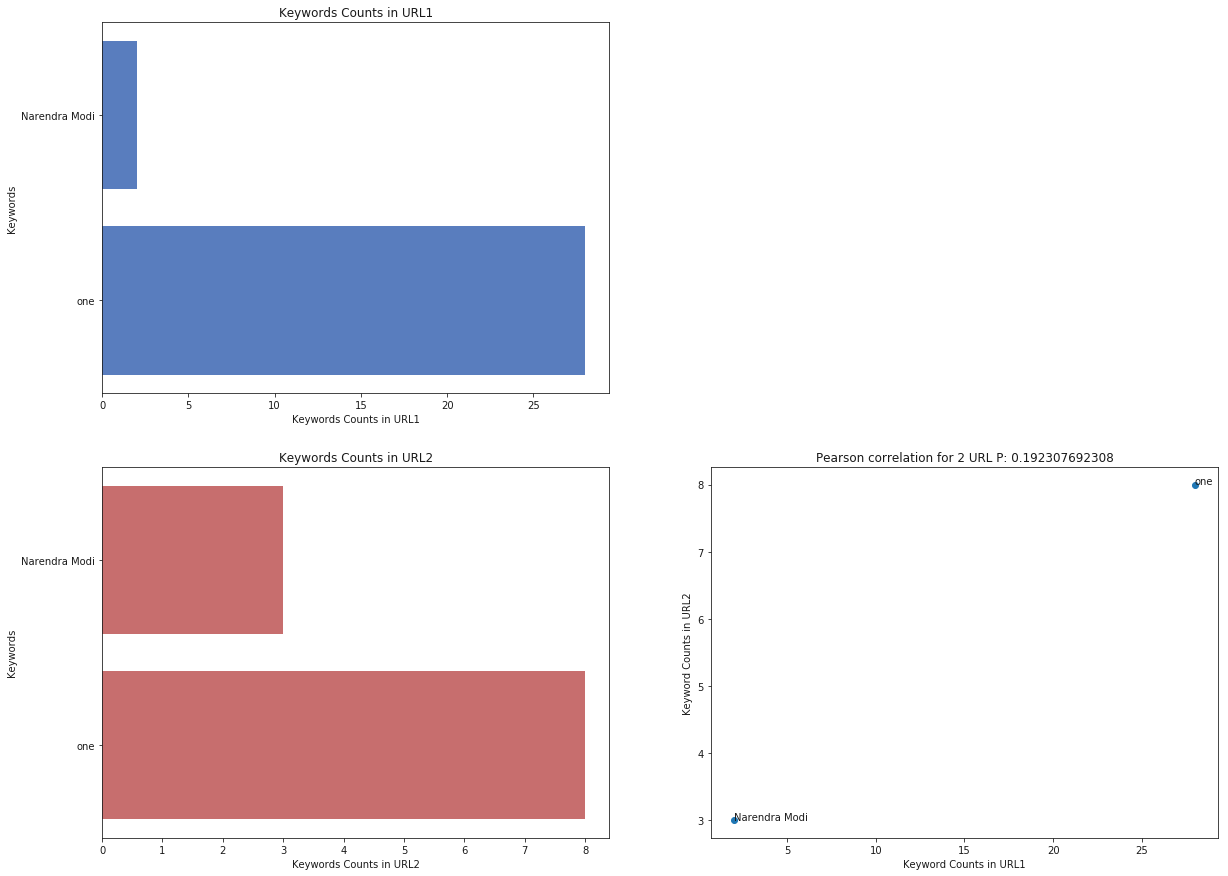

In [52]:
# Plot Graph 1 & 2
log_cols = ["Keywords", "Keyword Counts in URL1", "Keyword Counts in URL2"]
log = pd.DataFrame(columns=log_cols)

for index in range(0, len(keywords_list)):
    keyword = copy.deepcopy(keywords_list[index])
    keyword_count_url1 = copy.deepcopy(keywords_counts_url1[index])
    keyword_count_url2 = copy.deepcopy(keywords_counts_url2[index])
    log_entry = pd.DataFrame([[keyword, keyword_count_url1, keyword_count_url2]], columns=log_cols)
    log = log.append(log_entry, ignore_index=True)

# Plot Graph 1
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(221)
sns.set_color_codes("muted")
ax = sns.barplot(x="Keyword Counts in URL1", y="Keywords", data=log, color="b")
plt.title("Keywords Counts in URL1")
plt.xlabel("Keywords Counts in URL1")

# Plot Graph 2
ax = fig.add_subplot(223)
sns.set_color_codes("muted")
ax = sns.barplot(x="Keyword Counts in URL2", y="Keywords", data=log, color="r")
plt.title("Keywords Counts in URL2")
plt.xlabel("Keywords Counts in URL2")

# Plot Pearson Correlation Graph for 2 URL
df = pd.DataFrame({'keyword_counts_in_url1':log.iloc[:,1].astype(float), 'keyword_counts_in_url2':log.iloc[:,2].astype(float)})
P = (df.corr() * df['keyword_counts_in_url1'].std() * df['keyword_counts_in_url2'].std() / df['keyword_counts_in_url1'].var()).ix[0, 1]

ax = fig.add_subplot(224)
ax.scatter(keywords_counts_url1, keywords_counts_url2)
for i, txt in enumerate(keywords_list):
    ax.annotate(txt, (keywords_counts_url1[i], keywords_counts_url2[i]))
plt.xlabel("Keyword Counts in URL1")
plt.ylabel("Keyword Counts in URL2")
plt.title("Pearson correlation for 2 URL P: %s" % str(P))
plt.show()